In [2]:
#####################################
### Import the relevant libraries ###
#####################################
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
import pandas as pd
import sys
import os
from tensorflow import keras


os.chdir("/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO")


# Now you can import your module
from data import load_data, load_embeddings, load_pca, prepare_data_for_training
from train import train_base, train_adversarial
from results import calculate_accuracy, calculate_perturbations_accuracy, calculate_cosine_perturbations_filtering
from perturbations import create_perturbations
from hyperrectangles import load_hyperrectangles

ModuleNotFoundError: No module named 'data'

In [133]:
#Specify dataset, path, encoding model, perturbation type etc and ensure that all data is regenerated
load_saved_embeddings = False
load_saved_align_mat = False
load_saved_pca = False
load_saved_perturbations = False
load_saved_hyperrectangles = False
from_logits = True

dataset_names = ['medical']
#written as dict to easily expand for other models - add in a few others
encoding_models = {'all-MiniLM-L6-v2': 'sbert22M'}
og_perturbation_name = 'original'
perturbation_names = ['character']
hyperrectangles_names = {'character': ['character']}

# Derived variables
dataset_name = dataset_names[0]
encoding_model = list(encoding_models.keys())[0]
encoding_model_name = encoding_models[encoding_model]
perturbation_name = perturbation_names[0]
hyperrectangles_name = list(hyperrectangles_names.keys())[0]
path = "/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/datasets"



In [ ]:
#Clean and embed dataset using ANTONIO tools

X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos, y_train_neg, y_test_pos, y_test_neg= load_data(dataset_name, path=path)
data_o = X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos, y_train_neg, y_test_pos, y_test_neg #easier for later adversarial training
data_cleaned = X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos, y_train_neg, y_test_pos, y_test_neg
X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o, y_train_pos_o, y_train_neg_o, y_test_pos_o, y_test_neg_o = load_embeddings(dataset_name, encoding_model, encoding_model_name, og_perturbation_name, load_saved_embeddings, load_saved_align_mat, data_cleaned, path)
print(f'Train pos sentence embeddings shape: {X_train_pos_embedded_o.shape}')
print(f'Train neg sentence embeddings shape: {X_train_neg_embedded_o.shape}')
print(f'Test pos sentence embeddings shape: {X_test_pos_embedded_o.shape}')
print(f'Test neg sentence embeddings shape: {X_test_neg_embedded_o.shape}')

#note that output embeddings have already been rotated to principal axes but PCA not undertaken yet!

/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/src/data.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['query-label-expert'] = pos['query-label-expert'].replace({1: 0, 2: 0, 3: 0})
/Users/fleurconway/Documents/Programming/F21ZK_Verification_and_Validation/ANTONIO/src/data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg['query-label-expert'] = neg['query-label-expert'].replace({0: 1})


(989, 384)
Train pos sentence embeddings shape: (989, 384)
Train neg sentence embeddings shape: (1052, 384)
Test pos sentence embeddings shape: (424, 384)
Test neg sentence embeddings shape: (451, 384)


Visualise dataset

In [135]:
#Quick look at actual strings
# Show the first 5 rows of medical queries (X_train_pos)
for i in range(3):
    print(f"Label: {y_train_pos[i]} | Sentence: {X_train_pos[i]}")
for i in range(3):
    print(f"Label: {y_train_neg[i]} | Sentence: {X_train_neg[i]}")

Label: 0 | Sentence: Why do i get a bad headache when i don't eat enough during the day?
Label: 0 | Sentence: What causes heart rate to suddenly quicken to 100 resting after pressure on back for a while - with difficulty breathing?
Label: 0 | Sentence: peritonsillar abscess drainage aftercare.. please help
Label: 1.0 | Sentence: If humans were not restrained by the obstetrical dilemma, how many weeks, on average, would a fetus take to naturally gestate inside the womb before birth, and and how large would it get?
Label: 1.0 | Sentence: Writer with a question: What kind of medical situations do you have to inform the police about?
Label: 1.0 | Sentence: Reddit, I need your help making a decision.


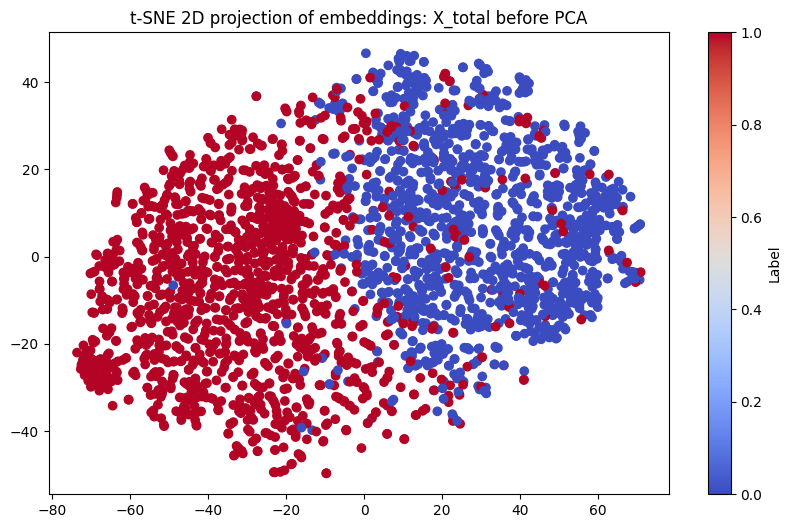

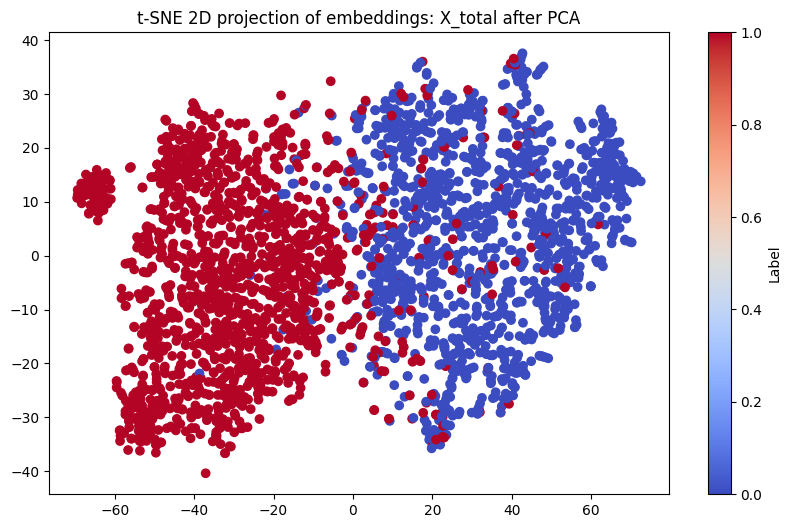

In [136]:
#for visualisation I consulted the paper: Li et al. - 2016 - Visualizing and Understanding Neural Models in NLP
#this lists 60dheatmaps for representation of selected words/phrases/sentences
#it also refers to t-sne (Maaten and Hinton - 2008 - Visualizing Data using t-SNE) which comes in scikit-learn
#interesting to do this both before and after PCA. before PCA to show gauge semantic meaning in the structure and after to see how the dimensionality reduction and alignment changes this 


#need to concatenate data in order to visualise clusters - don't use ANTONIO function for this as batches the training and test data
X_total_before_PCA = np.concatenate((X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o), axis=0)
y_total= np.concatenate((y_train_pos_o, y_train_neg_o, y_test_pos_o, y_test_neg_o), axis=0)


def display_some_examples(X_data, y_data, n_examples= None, X_name = "X_data"):
    tsne = TSNE(n_components=2, random_state=42)
    examples_2d = tsne.fit_transform(X_data)

    plt.figure(figsize=(10,6))
    plt.scatter(examples_2d[:n_examples,0], examples_2d[:n_examples,1], c=y_data[:n_examples], cmap='coolwarm')
    plt.colorbar(label='Label')
    plt.title(f"t-SNE 2D projection of embeddings: {X_name}")
    plt.show()

display_some_examples(X_total_before_PCA, y_total, n_examples=None, X_name = "X_total before PCA")

#now do the same but after PCA! note that PCA components selected as 30
n_components = 30
X_train_pos, X_train_neg, X_test_pos, X_test_neg = load_pca(dataset_name, encoding_model_name, load_saved_pca, X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o, n_components, path=path)
X_total_after_PCA = np.concatenate((X_train_pos, X_train_neg, X_test_pos, X_test_neg), axis=0)
display_some_examples(X_total_after_PCA, y_total, n_examples=None, X_name = "X_total after PCA")


***
# **BASE TRAINING**

In [137]:
##########################
### Set some variables and train###
##########################

input_size = n_components  # e.g., 384 for SBERT but reduced by PCA to 30
batch_size = 64 # as used in ANTONIO
epochs = 30 #as used in ANTONIO
n_classes = 2 #binary classification
epsilon = 0.3 #from lab code
alpha = 0.1 #from lab code
num_iter = 10 #from lab code

#from ANTONIO code
# n_components = 30
# batch_size = 64
seed = 42
# epochs = 30
pgd_steps = 5 


In [138]:
########################
### Define the model ###
########################
# could add more or denser layers (dense(256)) or switch to CNN,  or try softmax for multi-class, or add regularisation
#Marco's paper says they train a medium-sized fully-connected DNN (with 2 layers of size (128, 2) and input size 30) using stochastic gradient descent and cross-entropy loss
#from Marcos ANTONIO code
def get_model(n_components):
    inputs = keras.Input(shape=(n_components,), name="embeddings")
    x = keras.layers.Dense(128, activation="relu", name="dense_1")(inputs)
    outputs = keras.layers.Dense(2, activation="linear", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model


In [139]:
##########################
### Train a base model and provide metrics using ANOTONIO toolbox###
##########################

#try to use ANTONIO fields here
# Prepare the data for training, already did first line but run again to be careful
X_train_pos, X_train_neg, X_test_pos, X_test_neg = load_pca(dataset_name, encoding_model_name, load_saved_pca, X_train_pos_embedded_o, X_train_neg_embedded_o, X_test_pos_embedded_o, X_test_neg_embedded_o, n_components, path=path)
train_dataset, test_dataset = prepare_data_for_training(X_train_pos, X_train_neg, X_test_pos, X_test_neg, y_train_pos_o, y_train_neg_o, y_test_pos_o, y_test_neg_o, batch_size)

# Train and save the base model or adversarial model
model_path = f'{path}/{dataset_name}/models/tf/{encoding_model_name}'
if not os.path.exists(model_path):
    os.makedirs(model_path)
n_samples = int(len(X_train_pos))

model = get_model(n_components)
model = train_base(model, train_dataset, test_dataset, epochs, seed=seed, from_logits=from_logits)
model.save(f'{model_path}/base_{seed}')

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3968      
                                                                 
 predictions (Dense)         (None, 2)                 258       
                                                                 
Total params: 4226 (16.51 KB)
Trainable params: 4226 (16.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1
Train acc: 0.8207, Train loss: 0.6273 --- Test acc: 0.8229, Test loss: 0.6279 --|-- Time: 0.24s

Epoch 2
Train acc: 0.9373, Train loss: 0.5401 --- Test acc: 0.9531, Test loss: 0.5432 --|-- Time: 0.22s

Epoch 3
Train acc: 0.9422, Train loss: 0.4406 --- Test acc: 0.9486, Test loss: 0.4456 --|-- Time: 0.21s

Epoch 4
Train acc: 0.9412, Train loss: 0.3467 --- Test acc: 0.9451, Test loss: 0.3530 --|-- Time: 0.21s

Epoch 5
Train acc: 0.9407, Train loss: 0.2764 --- Test acc: 0.9451, Test loss: 0.2823 --|-- Time: 0.22s

Epoch 6
Train acc: 0.9437, Train loss: 0.2307 --- Test acc: 0.9417, Test loss: 0.2359 --|-- Time: 0.22s

Epoch 7
Train acc: 0.9446, Train loss: 0.2021 --- Test acc: 0.9406, Test loss: 0.2064 --|-- Time: 0.22s

Epoch 8
Train acc: 0.9456, Train loss: 0.1845 --- Test acc: 0.9406, Test loss: 0.1879 --|-- Time: 0.21s

Epoch 9
Train acc: 0.9486, Train loss: 0.1727 --- Test acc: 0.9406, Test loss: 0.1748 --|-- Time: 0.22s

Epoch 10
Train acc: 0.9495, Train loss: 0.1655 --

In [140]:
#Perform PGD attack - this requires perturbations, will use ANTONIO for this
# Create the perturbations and embed them
data_p = create_perturbations(dataset_name, perturbation_name, data_o, path)
X_train_pos_embedded_p, X_train_neg_embedded_p, X_test_pos_embedded_p, X_test_neg_embedded_p, y_train_pos_p, y_train_neg_p, y_test_pos_p, y_test_neg_p = load_embeddings(dataset_name, encoding_model, encoding_model_name, perturbation_name, load_saved_perturbations, load_saved_align_mat, data=data_p, path=path)

 # Create the hyper-rectangles
hyperrectangles = load_hyperrectangles(dataset_name, encoding_model_name, hyperrectangles_name, load_saved_hyperrectangles, path=path)

model = get_model(n_components)
model = train_adversarial(model, train_dataset, test_dataset, hyperrectangles, epochs, batch_size, n_samples, pgd_steps, seed=seed, from_logits=from_logits)
model.save(f'{model_path}/{perturbation_name}_{seed}')
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

(4945, 384)
(29, 30, 2)
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (InputLayer)     [(None, 30)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3968      
                                                                 
 predictions (Dense)         (None, 2)                 258       
                                                                 
Total params: 4226 (16.51 KB)
Trainable params: 4226 (16.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1
Train acc: 0.9035, Train loss: 0.6262 --- Test acc: 0.9063, Test loss: 0.6265 --- Time: 0.66s

Epoch 2
Train acc: 0.9432, Train loss: 0.5372 --- Test acc: 0.9440, Test loss: 0.5406 --- Time: 0.64s

Epoch 3
Train acc: 0.9466, Train loss: 0.4311 --- Test acc: 0.9371, Test loss: 0.4374 --- Time: 0.64s

Epoch 4
Train acc: 0.9476, Train loss: 0.3327 --- Test acc: 0.9406, Test loss: 0.3401 --- Time: 0.63s

Epoch 5
Train acc: 0.9461, Train loss: 0.2627 --- Test acc: 0.9417, Test loss: 0.2700 --- Time: 0.63s

Epoch 6
Train acc: 0.9476, Train loss: 0.2186 --- Test acc: 0.9371, Test loss: 0.2242 --- Time: 0.62s

Epoch 7
Train acc: 0.9490, Train loss: 0.1933 --- Test acc: 0.9383, Test loss: 0.1981 --- Time: 0.62s

Epoch 8
Train acc: 0.9486, Train loss: 0.1773 --- Test acc: 0.9394, Test loss: 0.1805 --- Time: 0.63s

Epoch 9
Train acc: 0.9505, Train loss: 0.1676 --- Test acc: 0.9394, Test loss: 0.1705 --- Time: 0.63s

Epoch 10
Train acc: 0.9510, Train loss: 0.1614 --- Test acc: 0.9383

2025-09-28 20:36:35.572923: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train acc: 0.9579, Train loss: 0.1370 --- Test acc: 0.9406, Test loss: 0.1447 --- Time: 0.63s

Epoch 24
Train acc: 0.9569, Train loss: 0.1365 --- Test acc: 0.9417, Test loss: 0.1454 --- Time: 0.63s

Epoch 25
Train acc: 0.9569, Train loss: 0.1355 --- Test acc: 0.9417, Test loss: 0.1445 --- Time: 0.62s

Epoch 26
Train acc: 0.9579, Train loss: 0.1346 --- Test acc: 0.9394, Test loss: 0.1454 --- Time: 0.62s

Epoch 27
Train acc: 0.9574, Train loss: 0.1333 --- Test acc: 0.9406, Test loss: 0.1438 --- Time: 0.62s

Epoch 28
Train acc: 0.9593, Train loss: 0.1321 --- Test acc: 0.9417, Test loss: 0.1435 --- Time: 0.62s

Epoch 29
Train acc: 0.9598, Train loss: 0.1314 --- Test acc: 0.9394, Test loss: 0.1440 --- Time: 0.62s

Epoch 30
Train acc: 0.9598, Train loss: 0.1301 --- Test acc: 0.9417, Test loss: 0.1432 --- Time: 0.63s


In [141]:
calculate_accuracy(dataset_names, encoding_models, batch_size, path=path)
calculate_perturbations_accuracy(dataset_names, encoding_models, perturbation_names, batch_size, path=path)
calculate_cosine_perturbations_filtering(dataset_names, encoding_models, perturbation_names, path=path)


character
